                     Accuracy  Macro Avg F1  Weighted Avg F1
Logistic Regression  0.745303      0.536928         0.724894
Random Forest        0.724426      0.547771         0.714122
XGBoost              0.722338      0.537572         0.712184


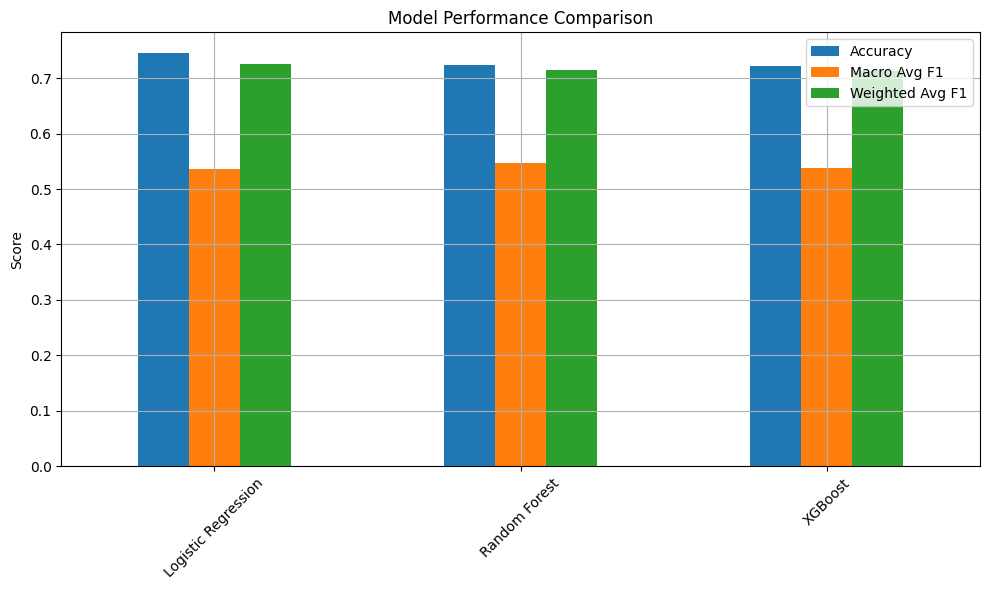

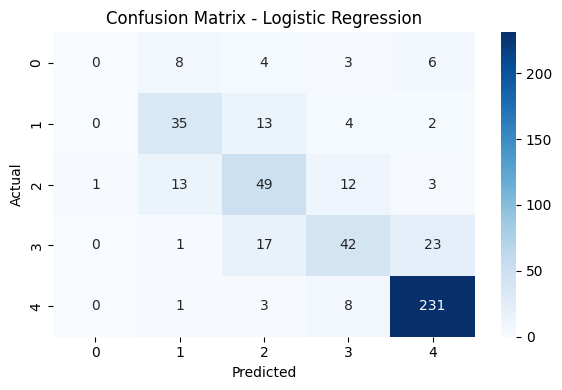

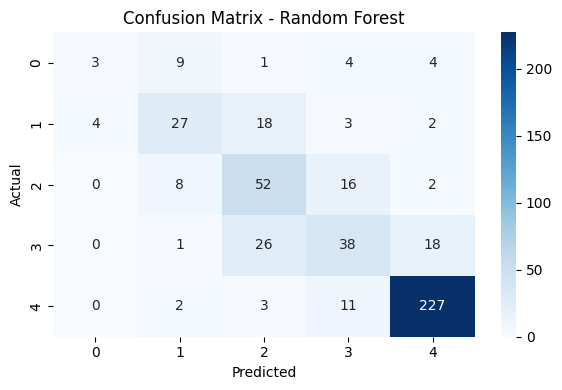

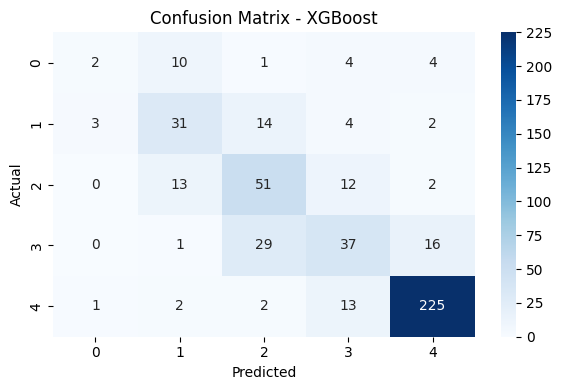

In [9]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

#Step 1: Load the test dataset
df_test = pd.read_csv('../data/test_data.csv', delimiter=",")
X = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y = df_test["GradeClass"]

#Step 2: Define model and optional scaler paths
model_paths = {
    'Logistic Regression': {
        'model': '../artifacts/regression_model.pkl',
        'scaler': '../artifacts/regression_scaler.pkl'
    },
    'Random Forest': {
        'model': '../artifacts/randomforest_model.pkl',
        'scaler': None
    },
    'XGBoost': {
        'model': '../artifacts/xgboost_model.pkl',
        'scaler': None
    }
}

#Step 3: Load models and optional scalers
trained_models = {}
scalers = {}

for name, paths in model_paths.items():
    with open(paths['model'], 'rb') as f:
        trained_models[name] = pickle.load(f)
    if paths['scaler']:
        with open(paths['scaler'], 'rb') as f:
            scalers[name] = pickle.load(f)

#Step 4: Evaluate each model
results = {}

for name, model in trained_models.items():
    X_input = scalers[name].transform(X) if name in scalers else X
    y_pred = model.predict(X_input)
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    results[name] = {
        'Accuracy': acc,
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score']
    }

#Step 5: Display results as bar chart
comparison_df = pd.DataFrame(results).T
print(comparison_df)

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#Step 6: Show confusion matrices for each model
for name, model in trained_models.items():
    X_input = scalers[name].transform(X) if name in scalers else X
    y_pred = model.predict(X_input)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
